In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.linear_model import *
from sklearn.datasets import fetch_openml, fetch_california_housing

In [3]:
### UTILITY FUNCTION FOR FEATURES PERMUTATION IMPORTANCE ###

def permut_features_importance(
    model, X, y, 
    loss_fun, n_repeats=10,
    seed=None, columns_name=None
):
    
    X = np.asarray(X)
    assert X.ndim == 2
    
    y = np.asarray(y)
    assert y.ndim < 2
    
    if seed is not None:
        np.random.seed(seed)
    
    if columns_name is not None:
        assert len(columns_name) == X.shape[-1]
    else:
        columns_name = np.arange(X.shape[-1])
        
    error = loss_fun(model, X, y)
    features_imp = {}
    std_features_imp = {}     
        
    for col in tqdm(range(X.shape[-1])):
        
        _importance = []
        for _ in range(n_repeats):
            
            _X = np.copy(X)
            _X[:,col] = np.random.permutation(_X[:,col])
            _importance.append(loss_fun(model, _X, y) - error)
                
        features_imp[columns_name[col]] = np.mean(_importance)
        std_features_imp[columns_name[col]] = np.std(_importance)
                
    return features_imp, std_features_imp

In [4]:
### UTILITY FUNCTION FOR SAMPLES PERMUTATION IMPORTANCE ###

def permut_sample_importance(
    model, X, y, 
    loss_fun, n_repeats=10,
    alpha=None, seed=None, columns_name=None
):
    
    X = np.asarray(X)
    assert X.ndim == 2
    
    y = np.asarray(y)
    assert y.ndim < 2
    
    if alpha is not None:
        assert alpha > 0 and alpha < 1
        
    if seed is not None:
        np.random.seed(seed)
        
    if columns_name is not None:
        assert len(columns_name) == X.shape[-1]
    else:
        columns_name = np.arange(X.shape[-1])
    
    dist_error = loss_fun(model, X, y, normalize=False)
    sample_imp = {}
    
    for col in tqdm(range(X.shape[-1])):
        
        _importance = []
        for _ in range(n_repeats):
        
            _X = np.copy(X)
            _X[:,col] = np.random.permutation(_X[:,col])
            dist_error_perm = loss_fun(model, _X, y, normalize=False)
            _importance.append(dist_error_perm - dist_error)
        
        if alpha is None:
            sample_imp[columns_name[col]] = np.quantile(
                np.asarray(_importance), 
                q = 0.5, axis = 0)
        else:
            sample_imp[columns_name[col]] = np.quantile(
                np.asarray(_importance), 
                q = [alpha/2, 0.5, 1-alpha/2], axis = 0).T
            
    return sample_imp

In [5]:
### LOSS FUNCTIONS ###

def mse(model, X, true, normalize=True): 
    
    if normalize:
        return np.mean(np.square(true - model.predict(X)))
    else:
        return np.square(true - model.predict(X)) 


def crossentropy(model, X, true, normalize=True):
    
    def _entropy(true, pred): return -(true * np.log(pred))
    
    true = np.asarray(true)
    classes = np.unique(true)
    pred_proba = model.predict_proba(X)
    pred_proba = pred_proba.clip(1e-5, 1 - 1e-5)
    
    c_entropy = np.zeros_like(true, dtype='float64')
    for c,cls in enumerate(classes):
        true_cls = (true == cls).astype(int)
        c_entropy += _entropy(true_cls, pred_proba[:,c])
    
    if normalize:
        return c_entropy.mean()
    else:
        return c_entropy

In [6]:
### UTILITY FUNCTIONS TO SUMMARIZE THE EFFECTS OF ALL THE FEATURES ###

def importance_heatmap(
    imp_values, X, n_bins=5
):
    
    imp_values = np.asarray(imp_values)
    sort_cols = np.argsort(np.mean(np.abs(imp_values), axis=0))[::-1]
    imp_values = imp_values[:,sort_cols]
    X = np.asarray(X)
    X = X[:,sort_cols]
    
    count, bins = np.histogram(imp_values, bins=n_bins)
    bins_inds = np.digitize(imp_values, bins[:-1])
    heatmap = np.zeros((imp_values.shape[1], n_bins)) *np.nan

    for c in range(imp_values.shape[1]):

        _ndx = np.argsort(bins_inds[:,c])
        _id, _pos, g_count  = np.unique(bins_inds[_ndx,c], 
                                        return_index=True, 
                                        return_counts=True)
        g_sum = np.add.reduceat(X[_ndx,c], _pos)
        g_mean = g_sum / g_count
        _id -= 1
        
        heatmap[np.ix_([c],_id)] = g_mean
        
        nan = np.isnan(heatmap[c])
        not_nan = np.logical_not(nan)
        interpolated = np.interp(nan.nonzero()[0], not_nan.nonzero()[0], g_mean)
        heatmap[np.ix_([c],nan)] = interpolated
        
    return heatmap, bins, sort_cols

def plot_importance_heatmap(
    imp_values, X, 
    n_bins=5, max_display=20, 
    feat_name=None
):
    
    heatmap, bins, sort_cols = importance_heatmap(imp_values, X, n_bins=n_bins)
    max_display = min(sort_cols.shape[0], max_display)
    heatmap = heatmap[:max_display]
    masks = np.asarray([np.arange(max_display)]*n_bins).T
    null = np.argmin(np.abs(bins))
    
    for m in range(masks.shape[0]):
        plt.imshow(np.ma.masked_array(heatmap, masks != m), cmap='plasma')
    
    if feat_name is None:
        feat_name = [f"feat_{c}" for c in sort_cols]
    else:
        feat_name = [feat_name[c] for c in sort_cols]
    
    plt.yticks(range(max_display), feat_name[:max_display])
    plt.colorbar(ticks=[-1], aspect=50, label='Feature values')
    plt.axvline(null, c='lime', linestyle='--')
    plt.xticks([0, null, n_bins-1], ['negative', 'null', 'positive'])
    plt.ylabel('Features (sorted by importance)')
    plt.xlabel('Permutation values (impact on model output)')

In [7]:
### UTILITY FUNCTIONS TO SUMMARIZE THE EFFECTS OF A FEATURE ON ALL THE CLASSES ###

def importance_heatmap_label(
    imp_values, X, y, n_bins=5
):
    
    imp_values = np.asarray(imp_values)
    y = np.asarray(y).ravel()
    X = np.asarray(X)
    
    labels = np.unique(y)
    count, bins = np.histogram(imp_values, bins=n_bins)
    bins_inds = np.digitize(imp_values, bins[:-1])
    heatmap = np.zeros((labels.shape[0], n_bins)) *np.nan

    for l,label in enumerate(labels):

        _ndx = np.argsort(X[y == label])
        _id, _pos, g_count  = np.unique(bins_inds[_ndx], 
                                        return_index=True, 
                                        return_counts=True)
        g_sum = np.add.reduceat(X[_ndx], _pos)
        g_mean = g_sum / g_count
        _id -= 1
        
        heatmap[np.ix_([l],_id)] = g_mean
        
        nan = np.isnan(heatmap[l])
        not_nan = np.logical_not(nan)
        interpolated = np.interp(nan.nonzero()[0], not_nan.nonzero()[0], g_mean)
        heatmap[np.ix_([l],nan)] = interpolated
        
    return heatmap, bins

def plot_importance_target_heatmap(
    imp_values, X, y,
    n_bins=5
):
    
    labels = np.unique(y)
    heatmap, bins = importance_heatmap_label(imp_values, X, y, n_bins=n_bins)
    null = np.argmin(np.abs(bins))

    plt.imshow(heatmap, cmap='plasma')
    plt.yticks(range(labels.shape[0]), labels)
    plt.colorbar(ticks=[-1], aspect=50, label='Feature values')
    plt.axvline(null, c='lime', linestyle='--')
    plt.xticks([0, null, n_bins-1], ['negative', 'null', 'positive'])
    plt.ylabel('Classes')
    plt.xlabel('Permutation values (impact on model output)')

# REGRESSION

In [8]:
### READ DATA AND FIT A SIMPLE MODEL ###

X, y = fetch_california_housing(return_X_y=True, as_frame=True)

m = Ridge()
m.fit(X,y)

error = mse(m, X, y)
error

0.5243210214822194

In [9]:
### COMPUTE FEATURES PERMUTATION IMPORTANCE ###

feat_imp_diz = permut_features_importance(m, X, y, loss_fun=mse, n_repeats=100, 
                                          columns_name=X.columns, seed=42)
feat_imp_mean, feat_imp_std = feat_imp_diz

feat_imp_mean = pd.Series(feat_imp_mean)
feat_imp_std = pd.Series(feat_imp_std)

order = feat_imp_mean.sort_values(ascending=False).index
feat_imp_mean = feat_imp_mean[order]
feat_imp_std = feat_imp_std[order]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:02<00:00,  3.42it/s]


Text(0, 0.5, 'importance')

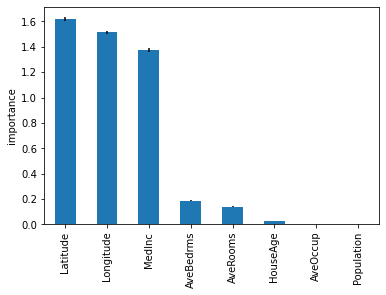

In [10]:
### PLOT FEATURES PERMUTATION IMPORTANCE ###

feat_imp_mean.plot.bar(yerr=feat_imp_std)
plt.ylabel('importance')

In [11]:
### COMPUTE SAMPLES PERMUTATION IMPORTANCE ###

imp_diz = permut_sample_importance(m, X, y, loss_fun=mse, alpha=None, n_repeats=100, 
                                   columns_name=X.columns, seed=42)

imp_df = pd.DataFrame({c : imp_diz[c].clip(*np.quantile(imp_diz[c], [0.05,0.95])) for c in imp_diz})
order = imp_df.columns[np.argsort(np.mean(np.abs(imp_df), axis=0))]
imp_df = imp_df[order]

imp_df.head()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:04<00:00,  1.91it/s]


,AveOccup,Population,AveBedrms,HouseAge,AveRooms,MedInc,Longitude,Latitude
0,0.001285,0.002254,-0.015174,0.074221,-0.111438,4.417535,3.879119,1.305102
1,-0.001917,0.004436,0.044434,0.030975,0.068576,2.656413,1.368519,3.196202
2,-0.000051,-0.000860,-0.004781,-0.011439,0.206165,1.967909,0.817332,2.915569
3,0.000403,0.000914,0.009356,0.103807,-0.015751,1.477602,3.420144,1.820008
4,0.003802,0.004179,0.031326,0.302469,-0.177004,0.435225,3.406667,-0.259583


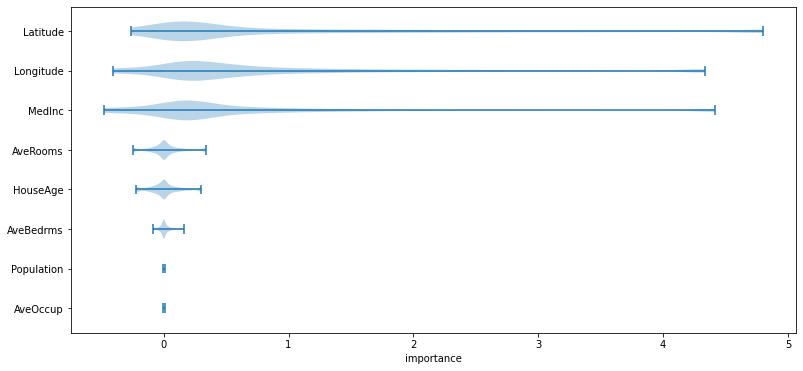

In [12]:
### PLOT SAMPLE PERMUTATION IMPORTANCE SCORES ###

plt.figure(figsize=(13,6))

plt.violinplot(dataset = imp_df.values, vert = False)
plt.yticks(range(1,imp_df.shape[1]+1), imp_df.columns); plt.xlabel('importance')
np.set_printoptions(False)

<AxesSubplot:>

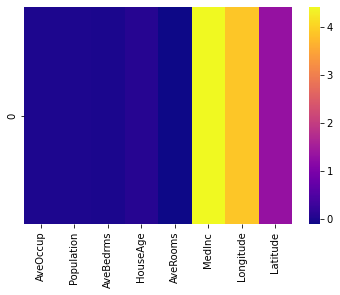

In [13]:
### PLOT IMPORTANCE FOR SINGLE OBSEVATION ###

sns.heatmap(imp_df.iloc[[0]], cmap = 'plasma')

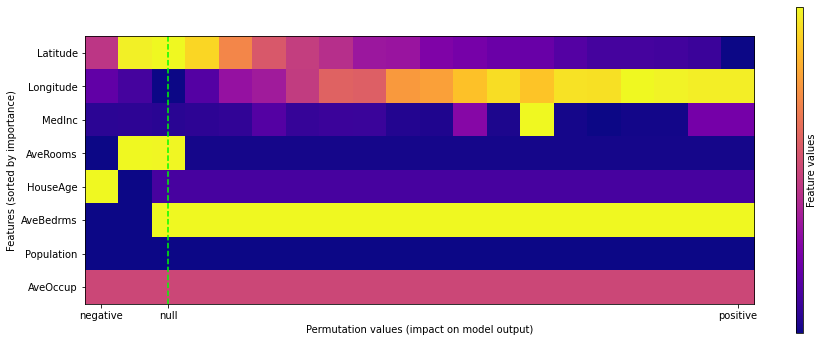

In [14]:
### SUMMARIZE THE EFFECTS OF ALL THE FEATURES ###

plt.figure(figsize=(15,6))
plot_importance_heatmap(imp_df, X, n_bins=20, feat_name=imp_df.columns)

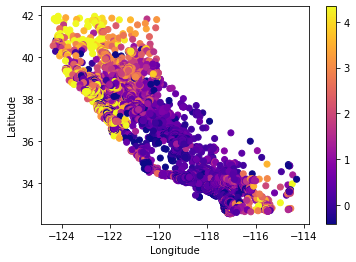

In [15]:
### PLOT IMPORTANCE FOR OBSEVATIONS WITH INTERACTIONS BETWEEN COLUMNS ###

plt.scatter(X['Longitude'], X['Latitude'], c=imp_df['Longitude'], cmap='plasma')
plt.xlabel('Longitude'); plt.ylabel('Latitude')
plt.colorbar()

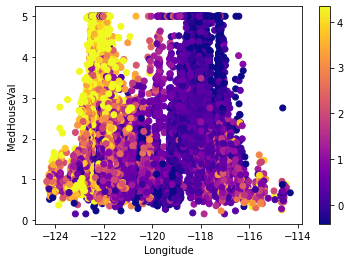

In [16]:
### PLOT IMPORTANCE FOR OBSEVATIONS WITH INTERACTIONS BETWEEN COLUMNS ###

plt.scatter(X['Longitude'], y, c=imp_df['Longitude'], cmap='plasma')
plt.xlabel('Longitude'); plt.ylabel(y.name)
plt.colorbar()

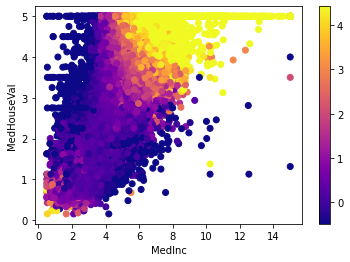

In [17]:
### PLOT IMPORTANCE FOR OBSEVATIONS WITH INTERACTIONS BETWEEN COLUMNS ###

plt.scatter(X['MedInc'], y, c=imp_df['MedInc'], cmap='plasma')
plt.xlabel('MedInc'); plt.ylabel(y.name)
plt.colorbar()

# CLASSIFICATION

In [18]:
### READ DATA AND FIT A SIMPLE MODEL ###

X, y = fetch_openml(name='wine-quality-red', return_X_y=True, as_frame=True)

m = LogisticRegression(C=10, max_iter=10_000)
m.fit(X,y)

error = crossentropy(m, X, y)
error

0.922306173107382

In [19]:
### COMPUTE FEATURES PERMUTATION IMPORTANCE ###

feat_imp_diz = permut_features_importance(m, X, y, loss_fun=crossentropy, n_repeats=100, 
                                          columns_name=X.columns, seed=42)
feat_imp_mean, feat_imp_std = feat_imp_diz

feat_imp_mean = pd.Series(feat_imp_mean)
feat_imp_std = pd.Series(feat_imp_std)

order = feat_imp_mean.sort_values(ascending=False).index
feat_imp_mean = feat_imp_mean[order]
feat_imp_std = feat_imp_std[order]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  4.20it/s]


Text(0, 0.5, 'importance')

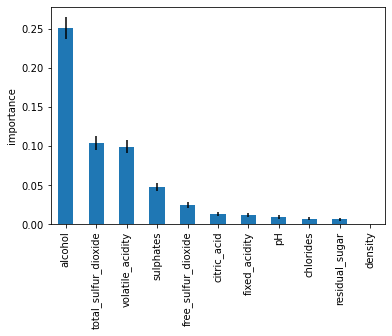

In [20]:
### PLOT FEATURES PERMUTATION IMPORTANCE ###

feat_imp_mean.plot.bar(yerr=feat_imp_std)
plt.ylabel('importance')

In [21]:
### COMPUTE SAMPLES PERMUTATION IMPORTANCE ###

imp_diz = permut_sample_importance(m, X, y, loss_fun=crossentropy, alpha=None, n_repeats=100, 
                                   columns_name=X.columns, seed=42)

imp_df = pd.DataFrame({c : imp_diz[c].clip(*np.quantile(imp_diz[c], [0.05,0.95])) for c in imp_diz})
order = imp_df.columns[np.argsort(np.mean(np.abs(imp_df), axis=0))]
imp_df = imp_df[order]

imp_df.head()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  4.14it/s]


,density,residual_sugar,pH,chlorides,fixed_acidity,free_sulfur_dioxide,citric_acid,sulphates,total_sulfur_dioxide,volatile_acidity,alcohol
0,0.000217,0.006246,-0.019282,-0.001123,0.014168,0.023349,-0.044583,0.030650,0.020131,0.121739,0.224232
1,-0.000011,-0.005135,0.005802,0.011254,0.004622,-0.049710,-0.053980,-0.027034,0.220818,0.337945,0.045817
2,0.000065,-0.000964,0.001959,0.008270,0.006519,-0.010534,-0.056035,-0.012802,0.041993,0.231419,0.067622
3,-0.000210,-0.001272,0.004269,0.006789,0.148376,0.033130,-0.156770,-0.027418,-0.118722,0.386960,-0.069108
4,0.000198,0.007513,-0.019650,-0.002243,0.012829,0.008237,-0.056294,0.021217,0.006542,0.133437,0.224232


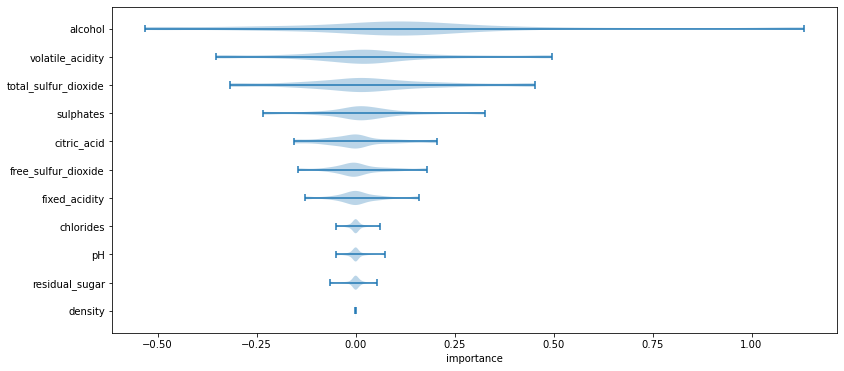

In [22]:
### PLOT SAMPLE PERMUTATION IMPORTANCE SCORES ###

plt.figure(figsize=(13,6))

plt.violinplot(dataset = imp_df.values, vert = False)
plt.yticks(range(1,imp_df.shape[1]+1), imp_df.columns); plt.xlabel('importance')
np.set_printoptions(False)

<AxesSubplot:>

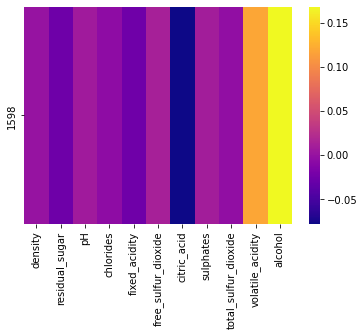

In [23]:
### PLOT IMPORTANCE FOR SINGLE OBSEVATION ###

sns.heatmap(imp_df.iloc[[-1]], cmap = 'plasma')

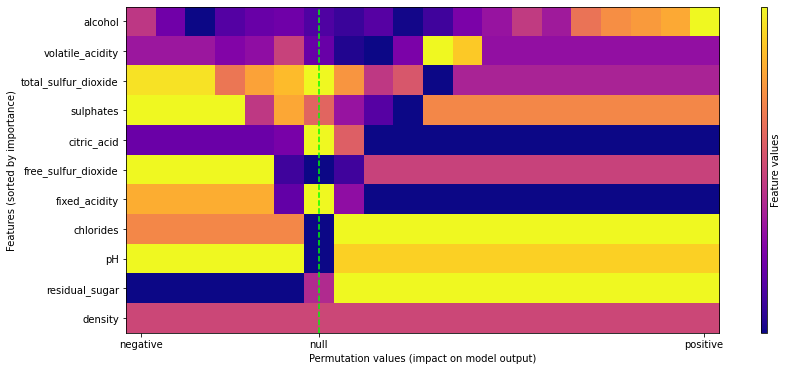

In [24]:
### SUMMARIZE THE EFFECTS OF ALL THE FEATURES ###

plt.figure(figsize=(15,6))
plot_importance_heatmap(imp_df, X, n_bins=20, feat_name=imp_df.columns)

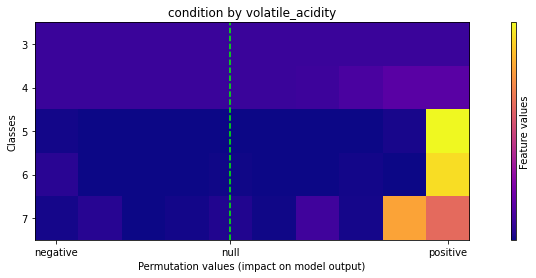

In [25]:
### SUMMARIZE THE EFFECTS OF A FEATURE ON ALL THE CLASSES ###

plt.figure(figsize=(15,4))

col = 'volatile_acidity'
plt.title(f"condition by {col}")
plot_importance_target_heatmap(imp_df[col], X[col], 
                               m.predict(X), n_bins=10)